# Quantum Entanglement Swapping circuito

In [1]:
# No olvidar que en "Google colab" hay que instalar qiskit

########################
# Instala versión 0.45.2
########################
# Importante, poner qiskit-aer en la misma linea de "pip install" para que coja la versión adecuada
try:
    import google.colab
    print("In colab, let's install things...")
    #
    !pip install qiskit[visualization]==0.45.2 qiskit-aer qiskit-ibm-runtime ipywidgets
except ImportError:
    print("NOT in colab")

In colab, let's install things...
INFO: pip is looking at multiple versions of qiskit-aer to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of qiskit-ibm-runtime to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of qiskit-ibm-runtime to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 49.3

In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import transpile
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import QFT
import numpy as np
import scipy.linalg as la
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, schmidt_decomposition
from qiskit.visualization import plot_bloch_multivector, array_to_latex, plot_state_qsphere

Vamos a crearnos los tres canales cuánticos para la comunicación entre Alice, Bob y Charly.

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


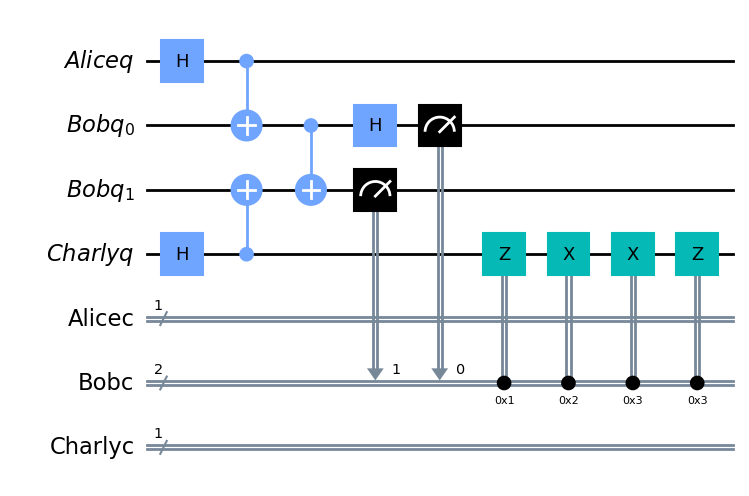

In [4]:
#Vamos a representar el circuito para entanglement swapping

qreg_Alice = QuantumRegister(1, 'Aliceq')
qreg_Bob = QuantumRegister(2, 'Bobq')
qreg_Charly = QuantumRegister(1, 'Charlyq')
creg_Alice = ClassicalRegister(1, 'Alicec')
creg_Bob = ClassicalRegister(2, 'Bobc')
creg_Charly = ClassicalRegister(1, 'Charlyc')
circuit = QuantumCircuit(qreg_Alice,qreg_Bob,qreg_Charly, creg_Alice,creg_Bob,creg_Charly)

#Vamos a construir los pares de bell para Alice/Bob y Bob/Charly
circuit.h(qreg_Alice[0])
circuit.h(qreg_Charly[0])
circuit.cx(qreg_Alice[0], qreg_Bob[0])
circuit.cx(qreg_Charly[0], qreg_Bob[1])
#Vamos a hacer entaglement entre los pares de Alice/Charly midiendo los de Charly
circuit.cx(qreg_Bob[0], qreg_Bob[1])
circuit.h(qreg_Bob[0])
circuit.measure(qreg_Bob[0], creg_Bob[0])
circuit.measure(qreg_Bob[1], creg_Bob[1])
#Charly y Bob se comunican por el canal clasico para para rectificar su par (simplemente para estar en |psi^+> como qubit estandar). Ver notas al final
circuit.z(qreg_Charly).c_if(creg_Bob,1)
circuit.x(qreg_Charly).c_if(creg_Bob,2)
circuit.x(qreg_Charly).c_if(creg_Bob,3) # En el caso de tener ambos qubits tenemos que aplicar flip y cambio de fase
circuit.z(qreg_Charly).c_if(creg_Bob,3)
circuit.draw('mpl')

In [10]:
#Para la comprobacion vamos a ver que los qubits de Alice y Charly estan entrelazados
circuit.measure(qreg_Alice[0], creg_Alice[0])
circuit.measure(qreg_Charly[0], creg_Charly[0])


# Generamos una instancia del simulador;
# con "method" le especificamos el método de simulación
# Change the method to 'qasm_simulator' to get counts
simulador = AerSimulator(method='statevector')

# Transpilamos
circuit_t = transpile(circuit, backend=simulador)

# Ejecutamos la simulación, con un buen número de repeticiones
# (shots = 1000), ya que tenemos un medidor
job = simulador.run(circuit_t, shots=10)
result = job.result()
counts = result.get_counts()



In [11]:
counts

{'1 01 1': 1, '1 10 1': 2, '0 11 0': 2, '0 01 0': 2, '0 10 0': 1, '1 00 1': 2}

In [28]:
for mediciones, veces in counts.items():
  print("============================")
  print("Para las mediciones:",mediciones)
  print("Alice obtuvo:",mediciones[0])
  print("Charly obtuvo:",mediciones[5])
  print("Mientras que Bob obtuvo:",mediciones[1:4])
  print("============================")


Para las mediciones: 1 01 1
Alice obtuvo: 1
Charly obtuvo: 1
Mientras que Bob obtuvo:  01
Para las mediciones: 1 10 1
Alice obtuvo: 1
Charly obtuvo: 1
Mientras que Bob obtuvo:  10
Para las mediciones: 0 11 0
Alice obtuvo: 0
Charly obtuvo: 0
Mientras que Bob obtuvo:  11
Para las mediciones: 0 01 0
Alice obtuvo: 0
Charly obtuvo: 0
Mientras que Bob obtuvo:  01
Para las mediciones: 0 10 0
Alice obtuvo: 0
Charly obtuvo: 0
Mientras que Bob obtuvo:  10
Para las mediciones: 1 00 1
Alice obtuvo: 1
Charly obtuvo: 1
Mientras que Bob obtuvo:  00


Concluimos con que Alice y Charly tenían un par de qubits entrelazados de Bell.

*Notas para saber que cambios aplicar según las mediciones de Bob:*

Al recibir $|00\rangle$ tenemos el estado $|\Phi^+\rangle$.

Al recibir $|01\rangle$ tenemos el estado $|\Phi^-\rangle$.

Al recibir $|10\rangle$ tenemos el estado $|\Psi^+\rangle$.

Al recibir $|11\rangle$ tenemos el estado $|\Psi^-\rangle$.